In [12]:
#Stratified sampling using 5% of data
import os
import pandas as pd
from sklearn.model_selection import train_test_split

folder_path = os.path.join(os.getcwd(), 'CIC')
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
chunksize = 500000
target_col = 'label'
label_mapping = {}

all_data_chunks = []
fraction_to_keep = 0.05  # keep 5% of every chunk

# Loop through all files
for csv_file in csv_files:
    csv_path = os.path.join(folder_path, csv_file)
    print(f'Processing file: {csv_file}') #I use this one for debugging it lists the file its working on, you can comment it out

    for chunk in pd.read_csv(csv_path, chunksize=chunksize):
        # Convert label
        if target_col in chunk.columns:
            if not label_mapping:
                unique_labels = chunk[target_col].unique()
                label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
            chunk[target_col] = chunk[target_col].map(label_mapping)

        # feature engineering
        if 'Tot sum' in chunk.columns and 'Duration' in chunk.columns:
            chunk['Packets_Duration_Ratio'] = chunk['Tot sum'] / (chunk['Duration'] + 1e-6)

        chunk_sampled = chunk.sample(frac=fraction_to_keep, random_state=42)
        all_data_chunks.append(chunk_sampled)

# Concatenate all sampled chunks
processed_data = pd.concat(all_data_chunks, ignore_index=True)
print(f"\nSubset data shape (before stratified sampling): {processed_data.shape}")
print("This should be roughly 5% of the original dataset.")

# print stats before sampling
def calculate_stats(df):
    stats_dict = {}
    for col in df.select_dtypes(include=[float, int]).columns:
        stats_dict[col] = {
            "Mean": df[col].mean(),
            "Mode": df[col].mode().iloc[0] if not df[col].mode().empty else None,
            "Max": df[col].max(),
            "Min": df[col].min(),
            "Standard Deviation": df[col].std()
        }
    return stats_dict

original_stats = calculate_stats(processed_data)
print("\nSummary Statistics Per Column (Before Stratified Sampling):")
for col, stats in original_stats.items():
    print(f"\n{col}:")
    for stat_name, value in stats.items():
        print(f"  {stat_name}: {value}")

# stratified sampling
if 'label' in processed_data.columns:
    stratified_sample, _ = train_test_split(
        processed_data,
        test_size=0.8,
        stratify=processed_data['label'],
        random_state=42
    )

    # Save sample
    selected_file = "combined_sampled_data.csv"
    stratified_sample.to_csv('stratified_sample.csv', index=False)
    print(f"\nSuccessfully generated a stratified 5% sample and saved to 'stratified_sample.csv'.\n")
else:
    raise KeyError("'label' column not found in the data for stratified sampling.")

# stats after sampling
sample_stats = calculate_stats(stratified_sample)

print("\nSummary Statistics Per Column (Stratified Sample):")
for col, stats in sample_stats.items():
    print(f"\n{col}:")
    for stat_name, value in stats.items():
        print(f"  {stat_name}: {value}")

# print label mapping
print("\nLabel Mapping:")
for label, num in label_mapping.items():
    print(f"  {label} -> {num}")

# difference in stats
difference_stats = {}
for col in sample_stats:
    difference_stats[col] = {}
    for stat_name in sample_stats[col]:
        if col in original_stats:
            diff_value = sample_stats[col][stat_name] - original_stats[col][stat_name]
        else:
            diff_value = None
        difference_stats[col][stat_name] = diff_value

# Print Differences
print("\nDifferences in Summary Statistics (Stratified Sample - Original):")
for col, stats in difference_stats.items():
    print(f"\n{col}:")
    for stat_name, value in stats.items():
        print(f"  {stat_name} Difference: {value}")

# Save Differences
difference_df = pd.DataFrame.from_dict({i: difference_stats[i] for i in difference_stats}, orient='index')
difference_df.to_csv('difference_stats.csv')
print("\nDifferences in statistics have been saved to 'difference_stats.csv'.")


Processing file: part-00000-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00001-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00002-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00003-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00004-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00005-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00006-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00007-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00008-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00009-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00010-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00011-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00012-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00013-363d1ba3-8

In [ ]:
#smote sampling retaining 5% of original data
import os
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler

folder_path = os.path.join(os.getcwd(), 'CIC')
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

chunksize = 500000
target_col = 'label'
label_mapping = {}

all_data_chunks = []
fraction_to_keep = 0.05  #keep 5% of each chunk

for csv_file in csv_files:
    csv_path = os.path.join(folder_path, csv_file)
    print(f'Processing file: {csv_file}')

    for chunk in pd.read_csv(csv_path, chunksize=chunksize):
        # Convert label 
        if target_col in chunk.columns:
            # Build label mapping if empty
            if not label_mapping:
                unique_labels = chunk[target_col].unique()
                label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
            chunk[target_col] = chunk[target_col].map(label_mapping) 

        # feature engineering
        if 'Tot sum' in chunk.columns and 'Duration' in chunk.columns:
            chunk['Packets_Duration_Ratio'] = chunk['Tot sum'] / (chunk['Duration'] + 1e-6)

        # Randomly keep only "fraction_to_keep" of the current chunk
        chunk_sampled = chunk.sample(frac=fraction_to_keep, random_state=42)

        all_data_chunks.append(chunk_sampled)

# Concatenate all sampled chunks into a single "subset_data"
subset_data = pd.concat(all_data_chunks, ignore_index=True)
print(f"\nSubset data shape (before SMOTE): {subset_data.shape}")
print("This should be roughly 20% of the original dataset.")

# Summaries before SMOTE 
print("\nSummary statistics for data BEFORE SMOTE:\n")
before_smote_stats = subset_data.describe()
print(before_smote_stats)

# class distribution before SMOTE
if target_col in subset_data.columns:
    class_distribution_before = subset_data[target_col].value_counts(dropna=False)
    print("\nClass distribution (BEFORE SMOTE):\n", class_distribution_before)

#  Apply SMOTE
if target_col in subset_data.columns:
    feature_cols = [col for col in subset_data.columns if col != target_col]
    X = subset_data[feature_cols]
    y = subset_data[target_col]

    # Normalize features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    print("\nApplying SMOTE for class imbalance handling...")
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

    # Rebuild into a DataFrame
    smote_data = pd.DataFrame(X_resampled, columns=feature_cols)
    smote_data[target_col] = y_resampled

    print(f"SMOTE data shape (after SMOTE): {smote_data.shape}")

    #  Summaries AFTER SMOTE
    print("\nSummary statistics for data AFTER SMOTE:\n")
    after_smote_stats = smote_data.describe()
    print(after_smote_stats)

    #  class distribution after SMOTE
    class_distribution_after = smote_data[target_col].value_counts(dropna=False)
    print("\nClass distribution (AFTER SMOTE):\n", class_distribution_after)

    #  Compare the summary stats 
    common_stats_index = before_smote_stats.index.intersection(after_smote_stats.index)
    common_columns = before_smote_stats.columns.intersection(after_smote_stats.columns)

    diff_stats = after_smote_stats.loc[common_stats_index, common_columns] - \
                 before_smote_stats.loc[common_stats_index, common_columns]

    print("\nDifference in summary statistics (AFTER - BEFORE):\n")
    print(diff_stats)

    #  Save stats and data to CSV 
    before_smote_stats.to_csv("before_smote_stats.csv")
    after_smote_stats.to_csv("after_smote_stats.csv")
    diff_stats.to_csv("difference_in_stats.csv", float_format="%.6f")
    subset_data.to_csv("subset_data.csv", index=False)
    smote_data.to_csv("smote_data.csv", index=False)

else:
    print("\nNo 'label' column found in subset_data. SMOTE skipped.")


Processing file: part-00000-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00001-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00002-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00003-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00004-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00005-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00006-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00007-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00008-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00009-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00010-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00011-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00012-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00013-363d1ba3-8

In [9]:
#Data diffusion model using 5% of chunk data

import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

class DataDiffusion:
    def __init__(self, random_state=42, noise_factor=0.01):
        """
        :param random_state: Seed for reproducibility.
        :param noise_factor: A multiplier that controls how much random noise is added relative to each feature's range.
        """
        self.random_state = random_state
        self.noise_factor = noise_factor
        np.random.seed(self.random_state)

    def fit_resample(self, X, y):
        """
        Fit-resample method analogous to SMOTE's interface.
        :param X: Features as a numpy array
        :param y: Target as a 1D array-like (shape: [n_samples]).
        :return: (X_resampled, y_resampled)
        """
        # If X is a DataFrame, convert to NumPy
        X = np.array(X)
        y = np.array(y)

        unique_classes, counts = np.unique(y, return_counts=True)
        max_count = np.max(counts)

        X_resampled = []
        y_resampled = []

        for cls in unique_classes:
            # Extract all samples of the current class
            X_class = X[y == cls]
            count_class = X_class.shape[0]

            # Keep the original samples
            X_resampled.append(X_class)
            y_resampled.append(np.array([cls] * count_class))

            # If this class has fewer samples than max_count, oversample it
            if count_class < max_count:
                diff = max_count - count_class

                # For noise scaling, get the feature-wise min/max for this class
                feat_min = X_class.min(axis=0)
                feat_max = X_class.max(axis=0)
                feat_range = feat_max - feat_min

                # Randomly select samples from this class to replicate
                indices = np.random.randint(low=0, high=count_class, size=diff)
                X_selected = X_class[indices]

                # Create random noise
                noise = np.random.normal(
                    loc=0.0,
                    scale=self.noise_factor * feat_range,
                    size=X_selected.shape
                )

                # Add noise to the selected samples
                X_synthetic = X_selected + noise
                
                X_resampled.append(X_synthetic)
                y_resampled.append(np.array([cls] * diff))

        # Concatenate everything into final arrays
        X_resampled = np.concatenate(X_resampled, axis=0)
        y_resampled = np.concatenate(y_resampled, axis=0)

        return X_resampled, y_resampled


def main():
    folder_path = os.path.join(os.getcwd(), 'CIC')
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

    chunksize = 500000
    target_col = 'label'
    label_mapping = {}

    all_data_chunks = []
    fraction_to_keep = 0.05  # keep 5% of each chunk

    # Read CSV in chunks and sample the data
    for csv_file in csv_files:
        csv_path = os.path.join(folder_path, csv_file)
        print(f'Processing file: {csv_file}')

        for chunk in pd.read_csv(csv_path, chunksize=chunksize):
            # Convert label to numeric if needed
            if target_col in chunk.columns:
                # Build label mapping if empty
                if not label_mapping:
                    unique_labels = chunk[target_col].unique()
                    label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
                chunk[target_col] = chunk[target_col].map(label_mapping)

            # # feature engineering
            # if 'Tot sum' in chunk.columns and 'Duration' in chunk.columns:
            #     chunk['Packets_Duration_Ratio'] = chunk['Tot sum'] / (chunk['Duration'] + 1e-6)

            # Randomly keep only "fraction_to_keep" of the current chunk
            chunk_sampled = chunk.sample(frac=fraction_to_keep, random_state=42)
            all_data_chunks.append(chunk_sampled)

    # Concatenate all sampled chunks into a single "subset_data"
    subset_data = pd.concat(all_data_chunks, ignore_index=True)
    print(f"\nSubset data shape (before data diffusion): {subset_data.shape}")
    print("This should be roughly 5% of each chunk, combined.")

    # Summaries before diffusion
    print("\nSummary statistics for data BEFORE data diffusion:\n")
    before_diffusion_stats = subset_data.describe()
    print(before_diffusion_stats)

    # class distribution before diffusion
    if target_col in subset_data.columns:
        class_distribution_before = subset_data[target_col].value_counts(dropna=False)
        print("\nClass distribution (BEFORE data diffusion):\n", class_distribution_before)

    # Apply the DataDiffusion approach
    if target_col in subset_data.columns:
        feature_cols = [col for col in subset_data.columns if col != target_col]
        X = subset_data[feature_cols]
        y = subset_data[target_col]

        # Normalize features
        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(X)

        print("\nApplying Data Diffusion for class imbalance handling...")
        diffuser = DataDiffusion(random_state=42, noise_factor=0.01)
        X_resampled, y_resampled = diffuser.fit_resample(X_scaled, y)

        # Rebuild into a DataFrame
        diffusion_data = pd.DataFrame(X_resampled, columns=feature_cols)
        diffusion_data[target_col] = y_resampled

        print(f"Data shape (after Data Diffusion): {diffusion_data.shape}")

        # Summaries AFTER data diffusion
        print("\nSummary statistics for data AFTER Data Diffusion:\n")
        after_diffusion_stats = diffusion_data.describe()
        print(after_diffusion_stats)

        # Show the class distribution after Data Diffusion
        class_distribution_after = diffusion_data[target_col].value_counts(dropna=False)
        print("\nClass distribution (AFTER Data Diffusion):\n", class_distribution_after)

        # Compare the summary stats
        common_stats_index = before_diffusion_stats.index.intersection(after_diffusion_stats.index)
        common_columns = before_diffusion_stats.columns.intersection(after_diffusion_stats.columns)

        diff_stats = after_diffusion_stats.loc[common_stats_index, common_columns] - \
                     before_diffusion_stats.loc[common_stats_index, common_columns]

        print("\nDifference in summary statistics (AFTER - BEFORE):\n")
        print(diff_stats)


        # Save stats and data to CSV
        before_diffusion_stats.to_csv("before_data_diffusion_stats.csv")
        after_diffusion_stats.to_csv("after_data_diffusion_stats.csv")
        diff_stats.to_csv("difference_in_stats.csv", float_format="%.6f")
        subset_data.to_csv("subset_data.csv", index=False)
        diffusion_data.to_csv("data_diffusion_data.csv", index=False)

    else:
        print("\nNo 'label' column found in subset_data. Data diffusion skipped.")


if __name__ == "__main__":
    main()


Processing file: part-00000-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00001-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00002-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00003-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00004-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00005-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00006-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00007-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00008-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00009-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00010-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00011-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00012-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00013-363d1ba3-8

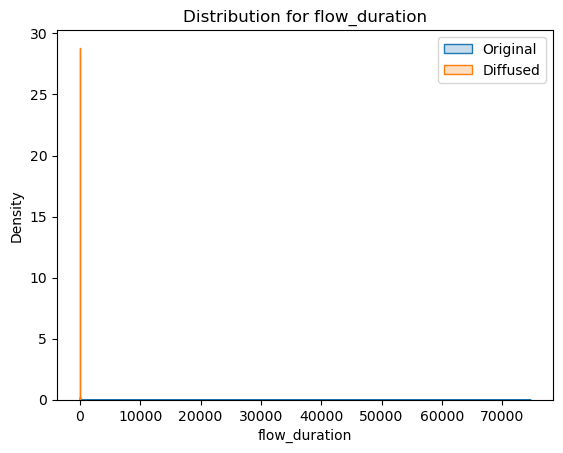

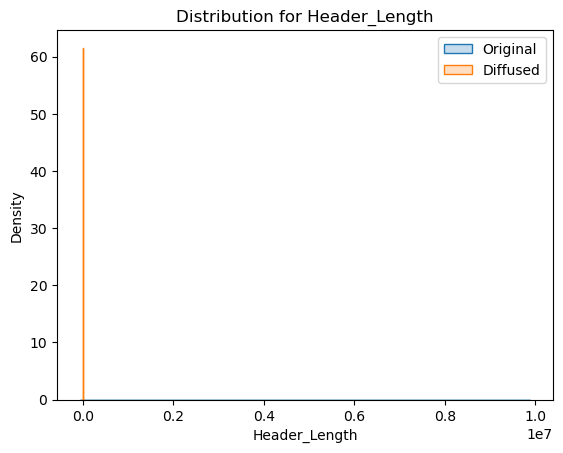

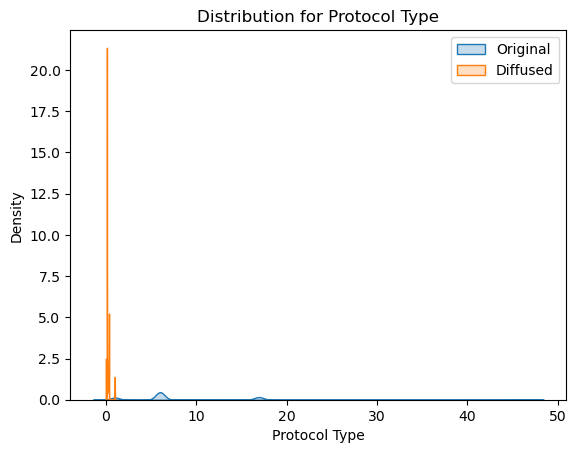

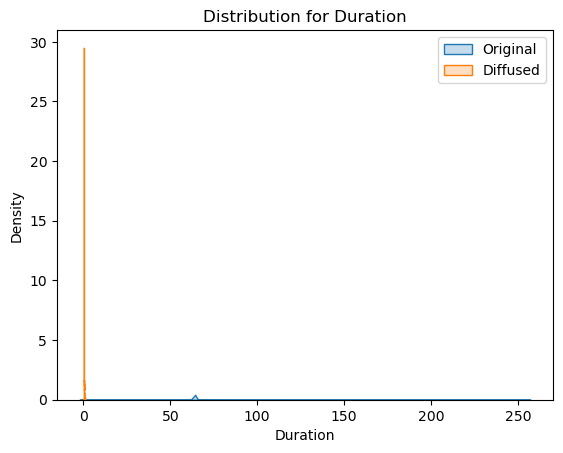

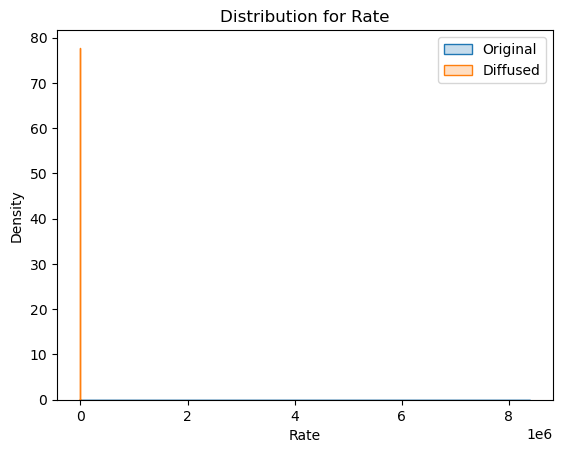

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

original_df = pd.read_csv("subset_data.csv")
sampled_df = pd.read_csv("data_diffusion_data.csv")

for col in original_df.columns[:5]:  # adjust as needed
    if col != 'label':
        sns.kdeplot(original_df[col], label='Original', fill=True)
        sns.kdeplot(sampled_df[col], label='Diffused', fill=True)
        plt.title(f'Distribution for {col}')
        plt.legend()
        plt.show()


In [1]:
#Undersampling
import os
import pandas as pd

def main():
    folder_path = os.path.join(os.getcwd(), 'CIC')
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

    chunksize = 500000
    target_col = 'label'
    label_mapping = {}

    sampled_chunks = []
    fraction_to_keep = 0.05  # Keeping 5% of each chunk

    for csv_file in csv_files:
        csv_path = os.path.join(folder_path, csv_file)
        print(f'Processing file: {csv_file}')

        for chunk in pd.read_csv(csv_path, chunksize=chunksize):
            # Convert label to numeric
            if target_col in chunk.columns:
                if not label_mapping:
                    unique_labels = chunk[target_col].unique()
                    label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
                chunk[target_col] = chunk[target_col].map(label_mapping)

            # Keep 5% of the chunk randomly
            chunk_sampled = chunk.sample(frac=fraction_to_keep, random_state=42)
            sampled_chunks.append(chunk_sampled)

    # Concatenate sampled data
    sampled_data = pd.concat(sampled_chunks, ignore_index=True)
    print(f"\nCombined sampled data shape: {sampled_data.shape}")

    # Class counts before undersampling
    print("\nClass distribution before undersampling:")
    before_counts = sampled_data[target_col].value_counts()
    print(before_counts)

    # Summary statistics before undersampling
    print("\nSummary statistics before undersampling:")
    before_stats = sampled_data.describe()
    print(before_stats)

    # Perform undersampling to match minority class
    min_class_size = sampled_data[target_col].value_counts().min()
    undersampled_data = sampled_data.groupby(target_col).apply(
        lambda x: x.sample(min_class_size, random_state=42)
    ).reset_index(drop=True)

    # Class distribution after undersampling
    print("\nClass distribution after undersampling:")
    after_counts = undersampled_data[target_col].value_counts()
    print(after_counts)

    # Summary statistics after undersampling
    print("\nSummary statistics after undersampling:")
    after_stats = undersampled_data.describe()
    print(after_stats)

    # Difference between class counts
    print("\nDifference in class distribution (before - after):")
    print(before_counts - after_counts)

    # Difference in summary statistics
    print("\nDifference in summary statistics (before - after):")
    stat_diff = before_stats - after_stats
    print(stat_diff)

    # Save undersampled data
    undersampled_data.to_csv("undersampled_data.csv", index=False)
    print("\nUndersampled data saved to 'undersampled_data.csv'")

if __name__ == "__main__":
    main()


Processing file: part-00000-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00001-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00002-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00003-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00004-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00005-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00006-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00007-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00008-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00009-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00010-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00011-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00012-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Processing file: part-00013-363d1ba3-8

C:\Users\vlad.serban\AppData\Local\Temp\ipykernel_44604\1280204711.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  undersampled_data = sampled_data.groupby(target_col).apply(



Class distribution after undersampling:
label
0     62
25    62
19    62
20    62
21    62
22    62
23    62
24    62
26    62
1     62
27    62
28    62
29    62
30    62
31    62
32    62
18    62
17    62
16    62
15    62
14    62
13    62
12    62
11    62
10    62
9     62
8     62
7     62
6     62
5     62
4     62
3     62
2     62
33    62
Name: count, dtype: int64

Summary statistics after undersampling:
       flow_duration  Header_Length  Protocol Type     Duration  \
count    2108.000000   2.108000e+03    2108.000000  2108.000000   
mean      124.832255   1.998209e+05      10.347034    80.004359   
std       880.572676   7.533693e+05       9.794445    33.332277   
min         0.000000   0.000000e+00       0.000000     0.000000   
25%         0.003591   5.800000e+01       6.000000    64.000000   
50%         1.173595   2.795330e+03       6.110000    64.000000   
75%        29.878884   3.156635e+04      11.000000    85.500000   
max     24943.064076   8.835409e+06      47.